In [5]:
# Ours
from work_variables import *

# Modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

from community import community_louvain as louvain
from netwulf import visualize

import requests
import re

import spacy
nlp = spacy.load("en_core_web_sm") # python -m spacy download en

# ---
# Get the book text data

book_request = requests.get(book_link)

assert book_request.status_code == 200, f"Request of the book failed. Status: {book_request.status_code}"


book_chapters = re.split(r'Chapter [0-9]+', book_request.text, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("End of Project Gutenberg")[0]

# Warning : indexes start at 1 !
book_chapters_paragraphs = dict()
real_persons_by_chapters = dict()

graph = nx.Graph()

In [6]:
# ---
# Cleaning, tokenization and graph filling

for i, chapter in enumerate(book_chapters):
    i = i+1

    # Split and clean up each paragraphs
    chapter_paragraphs = list()
    paragraphs = chapter.split('\r\n\r\n')
    for paragraph in paragraphs:
        clean_paragraph = re.sub(r"[\"\?\!\-\.\,\;\:\(\)\s]+", ' ', paragraph)
        chapter_paragraphs.append(clean_paragraph)

    book_chapters_paragraphs[i] = chapter_paragraphs

    # Tag and every detected person's name.
    tokens = nlp(''.join(chapter_paragraphs))
    chapter_persons = [ent.text for ent in tokens.ents if ent.label_ == "PERSON"]
    
    # Correct for all possible mentions of a person
    # And remove false positive
    real_chapter_persons = list()
    for person in chapter_persons:
        if person not in persons_real_names: 
            # We check if a corresponding name exists
            # Dictionary was made by hand
            for k,v in name_to_replace.items():
                reg = re.compile(k)
                # If something match
                if reg.match(person):
                    if v is None: break 
                    # Replace it by the correct one
                    real_chapter_persons.append(v)
        else: real_chapter_persons.append(person)

    unique_real_chapter_persons = list(set(real_chapter_persons))
    real_persons_by_chapters[i] = unique_real_chapter_persons

    # Add to the graph
    # Edges for each people in a chapter (?)
    graph.add_nodes_from(unique_real_chapter_persons)
    for idx in range(len(unique_real_chapter_persons)-1):
        graph.add_edge(unique_real_chapter_persons[idx], unique_real_chapter_persons[idx-1])

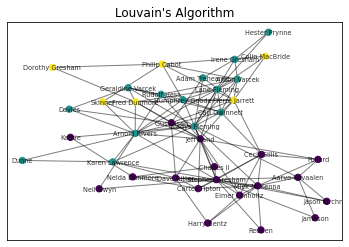

In [7]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

partition = louvain.best_partition(graph)

ass = nx.degree_assortativity_coefficient(graph)

# draw the graph
pos = nx.spring_layout(graph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.5)
nx.draw_networkx_labels(graph, pos, {n: n for n in partition}, font_size=6.5, alpha = 0.8)
plt.title("Louvain's Algorithm")
plt.show()

In [18]:
# ---
# K-Core decomposition
# Reworked version

def kcore(graph):

    knots, decomposition = {}, {}

    # Using the class Point() in work_variables.py
    # knots = [Point(person, list(graph.neighbors(person))) for person in graph.nodes]

    # Using a dictionary
    for person in graph.nodes:
        neighbors = list(graph.neighbors(person))
        knots[person] = {"neighbors": neighbors, "degree": len(neighbors), "pruned": False}

    k, total_pruned = 1, 0

    while total_pruned < len(graph):
        to_prune = [person for person,elems in knots.items() if elems['degree'] == k]
        k_shell = []
        while len(to_prune) > 0:
            x = to_prune.pop(0)
            for n in knots.get(x)['neighbors']:
                v = knots.get(n)
                if not v['pruned']:
                    v['degree'] -= 1
                    if v['degree'] == k : to_prune.append(n)
            knots.get(x)['pruned'] = True
            k_shell.append(x)
            total_pruned += 1
        decomposition[k] = sorted(k_shell)
        k += 1
    
    return decomposition 

kcore_output = kcore(graph)
                

In [21]:
print(kcore_output)

{1: [], 2: ['Dorothy Gresham', 'Dunne', 'Hester Prynne', 'Jameson', 'Kathie', 'Nell Gwyn', 'Reuben'], 3: ['Adam Trehearne', 'Charles II', 'Colin MacBride', 'Davies', 'Harry Bentz', 'Irene Gresham', 'Jason Kirchner', 'Nelda Dunmore'], 4: ['Aarvo Kavaalen', 'Anton Varcek', 'Arnold Rivers', 'Carl Gwinnett', 'Carter Tipton', 'Cecil Gillis', 'Dave Ritter', 'Elmer Umholtz', 'Fred Dunmore', 'Geraldine Varcek', 'Gladys Fleming', 'Gus Olsen', 'Humphrey Goode', 'Jeff Rand', 'Karen Lawrence', 'Lane Fleming', 'Mick McKenna', 'Philip Cabot', 'Pierre Jarrett', 'Pollard', 'Rudolf Hess', 'Skinner', 'Stephen Gresham']}
